#  Taxi order forecasting

The Taxi company has collected data on taxi orders at airports. To attract more drivers during the peak period, it is needed to predict the number of taxi orders for the next hour. A model for such a prediction must be built.

The value of the *RMSE* metric on the test set should not exceed 48.

**It is necessary:**

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.


## Data overview and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

Let's load the data and pass a new parse_dates argument.

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv',  index_col=[0], parse_dates=[0])

In [3]:
def info(df):
    df.info()
    print(100*'=')
    display(df.describe())
    print(100*'=')
    display(df.head())
    print(100*'=')
    display(f'Shape: {df.shape}')
    print(100*'=')
    print(f'Number of null values: {df.isna().mean()}')

    
info(df) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


'Shape: (26496, 1)'

Number of null values: num_orders    0.0
dtype: float64


Установим индекс. 

In [4]:
df.sort_index(inplace=True)

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
print(f'The table index attribute is monotonic: {df.index.is_monotonic}')

The table index attribute is monotonic: True


After the initial study of the data, we have at our disposal data with a volume of more than 26 thousand unique values. The first column shows the date, the second the number of orders.

The data in the `datetime` column was immediately converted to the correct format.

An index has been set.

## Analysis

Resampling one hour at a time.

In [7]:
df = df.resample("1H").sum()

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Plotting a time series.

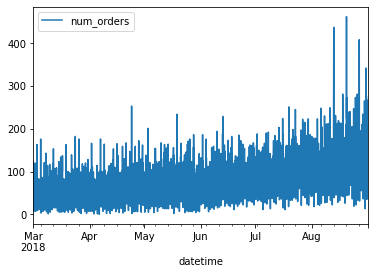

In [9]:
df.plot();

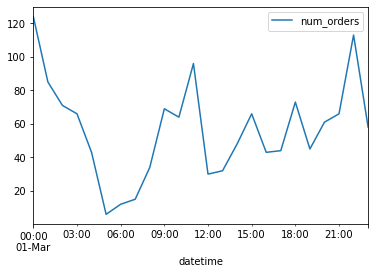

In [10]:
df['2018-03-01 00:00:00' : '2018-03-01 23:00:00'].plot();

It can be concluded that the data is relatively stable, but there is a gradual increase in the number of orders in the summer and at night and in the morning. 

Adding mean rolling which equals 30.

In [11]:
new_df = df - df.shift()

In [12]:
new_df['rolling_mean'] = new_df.rolling(30).mean()

In [13]:
new_df['rolling_std'] = new_df['num_orders'].rolling(30).std()

Studying trends and seasonality.

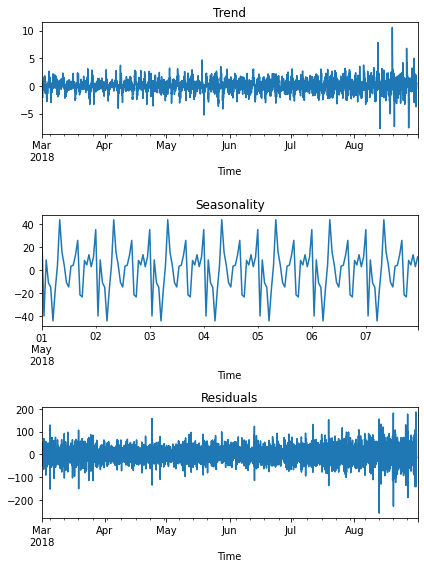

In [14]:
decomposed = seasonal_decompose(new_df['num_orders'].resample('1H').sum()) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Time')
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Time')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Time')
plt.tight_layout()

A trend of increasing the number of orders in the summer can be observed.

Calculating the time series differences and building a graph.

Time series is stationary.

## Model training

Creating make_features. 

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [16]:
make_features(df, 20, 20)

Splitting the dataset into training and test sets.`

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [19]:
def best_model(model, params, features_train, target_train):
    grid = GridSearchCV(model, param_grid = params, cv=splits,
                                            scoring = 'neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(features_train,target_train)


    return grid.best_score_*-1

In [20]:
splits = TimeSeriesSplit(n_splits=4)

The data is ready, let's move on to training. Random Forest, LightGBM, Catboost and linear regression models are chosen.

### RandomForest

In [21]:
%%time
rf_model = RandomForestRegressor(random_state=12345)
forestregressor_params = {'n_estimators':range(10, 31, 10),
             'max_depth':range (1,15)}
forest = best_model(rf_model, forestregressor_params, features_train, target_train)

CPU times: total: 2.67 s
Wall time: 36.7 s


In [22]:
print(f'RMSE of Random Forest: {forest:.2f}')

RMSE of Random Forest: 29.82


In [23]:
%%time
rf_model.fit(features_train, target_train)

CPU times: total: 6.22 s
Wall time: 6.22 s


RandomForestRegressor(random_state=12345)

In [24]:
%%time 
rf_model.predict(features_train)

CPU times: total: 93.8 ms
Wall time: 93.7 ms


array([ 62.7 ,  64.56, 100.3 , ..., 129.54, 100.5 , 112.9 ])

### LGBM

In [25]:
%%time
model_lgbm = LGBMRegressor(random_state=12345)
lgbm_params = {
    'n_estimators': [10,100],
    'max_depth': [1,30],
    'num_leaves': [10,31],
    'learning_rate': [0.1]
}
lgbm = best_model(model_lgbm, lgbm_params, features_train, target_train)

CPU times: total: 1.22 s
Wall time: 4.43 s


In [26]:
print(f'RMSE of LGBMRegressor: {lgbm:.2f}')

RMSE of LGBMRegressor: 29.29


In [27]:
%%time
model_lgbm.fit(features_train, target_train)

CPU times: total: 953 ms
Wall time: 252 ms


LGBMRegressor(random_state=12345)

In [28]:
%%time 
model_lgbm.predict(features_train)

CPU times: total: 125 ms
Wall time: 29.5 ms


array([ 67.86344884,  68.95954793,  94.22121857, ..., 131.73374828,
       108.23247632, 108.75455915])

### Catboost

In [29]:
%%time
model_catboost = CatBoostRegressor(random_state=42,silent=True)
catboost_params = {
    'learning_rate': [0.1],
    'iterations': [10,100],
    'max_depth': [1,15]
}
catboost = best_model(model_catboost, catboost_params, features_train, target_train)

CPU times: total: 703 ms
Wall time: 29min 28s


In [30]:
print(f'RMSE of CatBoostRegressor: {catboost:.2f}')

RMSE of CatBoostRegressor: 32.70


In [31]:
%%time
model_catboost.fit(features_train, target_train)

CPU times: total: 34.7 s
Wall time: 17.2 s


In [32]:
%%time
model_catboost.predict(features_train)

CPU times: total: 46.9 ms
Wall time: 27.1 ms


array([ 68.71900269,  61.09553623,  96.62116715, ..., 136.20875661,
       100.47964725, 109.77206663])

### Linear Regression

In [33]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: total: 62.5 ms
Wall time: 109 ms


LinearRegression()

In [34]:
%%time

lr_predictions = lr_model.predict(features_train)

CPU times: total: 31.2 ms
Wall time: 15.6 ms


In [35]:
lr_rmse = np.mean(np.sqrt(-cross_val_score
                          (lr_model, features_train, target_train, cv=splits, scoring="neg_mean_squared_error")))

In [36]:
print(f'RMSE of LinearRegression: {lr_rmse:.2f}') 

RMSE of LinearRegression: 31.58


Models are trained, let's analyze them.

In [37]:
table = pd.DataFrame({
    'model': ['RandomForest','LightGBM', 'Catboost', 'LinearRegression'],
    'time_train' : ['3.85 s', '884 ms','3.17 s','5.14 ms' ] , 
    'time_prediction' : ['83.6 ms','89.7 ms', '5.15 s', '11.8 ms'],
    'rmse': [forest, lgbm, catboost, lr_rmse]
})


In [38]:
display(table)

,model,time_train,time_prediction,rmse
0,RandomForest,3.85 s,83.6 ms,29.817495
1,LightGBM,884 ms,89.7 ms,29.290494
2,Catboost,3.17 s,5.15 s,32.699377
3,LinearRegression,5.14 ms,11.8 ms,31.582148


It can be seen that LightGBM is the model. Let's test it on a test sample.

## Testing

In [39]:
%%time

lgbm_pred = model_lgbm.predict(features_test)

CPU times: total: 31.2 ms
Wall time: 15.6 ms


In [40]:
print('RMSE on test sample:', round(mean_squared_error(lgbm_pred, target_test) ** 0.5))

RMSE on test sample: 48


## Summary.

In the course of the work, data were analyzed and models were built.

- Resamplication was performed by the hour.
- A seasonal increase in orders in the summer can be observed.
- Our series is stationary, so it can be used for forecasting.
- The following models have been selected: `RandomForest`, `LightGBM`, `Catboost` and `LinearRegression`.
- The best result was shown by the LightGBM model. It trains fast and has a low RMSE.
- After testing on a test sample, it showed a good result.